In [5]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, Layout, IntSlider
%matplotlib notebook

import pyaudio

In [6]:
# n = dimension, m = order, value must be an integer in the range [0, n*m)
def decode(value, n, m):
    W = 0
    N = n * m    
    shift = 0
    ans = [0] * n
    mask = ((1 << n) - 1)
    for i in range(m):
        J = n
        rs = N - i * n - n
        ls = n - shift
        ls2 = m - i - 1
        byte = (value >> rs) & mask 
        p = byte ^ (byte >> 1)
        lsb = byte & 1
        sub = byte - 2 + lsb
        bgt0 = 1 - (((byte - 1) >> n) & 1)
        t =  bgt0 * (sub ^ (sub >> 1))
        tS = (p >> shift) | (p << ls)
        tT = (t >> shift) | (t << ls)
        alpha = W ^ tS
        W = W ^ tT
        #iterate backwards so we can combine split loop and finding J
        for j in range(n - 1, -1, -1): 
            ans[n - j - 1] += ((alpha >> j) & 1) << ls2  
            if ((byte >> j) & 1) != lsb:
                J = n - j
        shift += (J - 1)
        if (shift > n):
            shift -= n
    return ans

def test_coords(n, m):
    N = n * m
    coord1 = tuple([0] * n)
    coord2 = None
    for i in range(1, 1 << N):
        t = decode(i, n, m)
        coord2 = tuple(t)
        diff = abs(np.asarray(coord1) - np.asarray(coord2))
        assert(np.sum(diff) == 1)
        coord1 = coord2

test_coords(3,4)
test_coords(4,3)
test_coords(5,2)
test_coords(5,3)
test_coords(4,4)
test_coords(7,2)

<IPython.core.display.Javascript object>


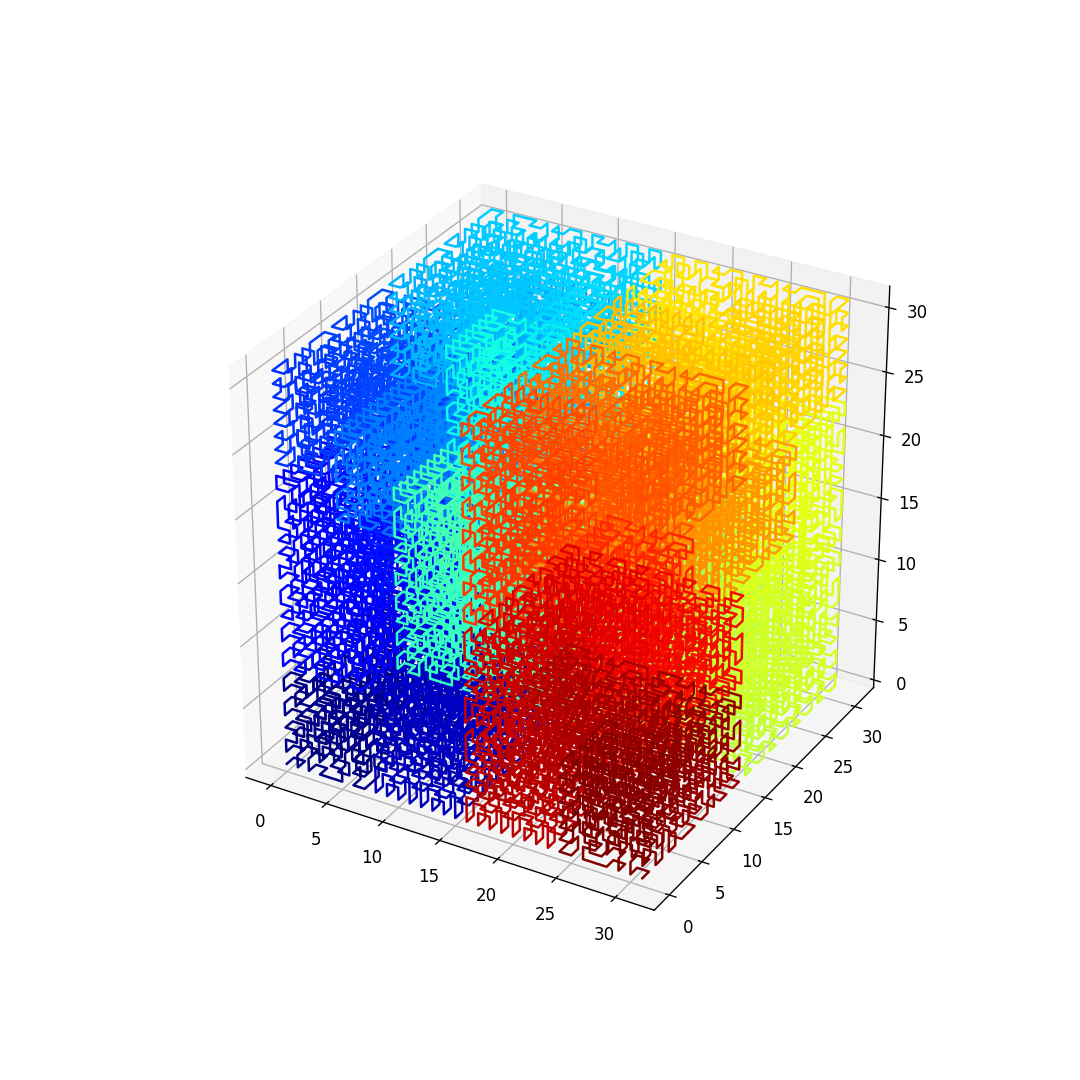

In [7]:
dimension = 3
order = 5
N = dimension * order

fig = plt.figure(figsize=(9,9))
ax = plt.axes(projection = '3d')

xs = []
ys = []
zs = []
coords = []
for i in range(1<<N):
    t = decode(i, dimension, order)
    xs.append(t[0])
    ys.append(t[1])
    zs.append(t[2])
    coords.append(tuple(t))

if N >= 9:
    region_size = 1<<(N-8)
    for i in range(1<<8):
        b = i * region_size
        e = b + region_size + 1
        ax.plot(xs[b:e], ys[b:e], zs[b:e], color=plt.cm.jet(i))
else:
    ax.plot(xs, ys, zs)
plt.show()

In [10]:
CHUNK = 201
FORMAT = pyaudio.paInt16
CHANNELS = 1
RATE = 44100
SECONDS = 4

p = pyaudio.PyAudio()
stream = p.open(format=FORMAT, channels=CHANNELS, rate=RATE, output=True, frames_per_buffer=CHUNK)

<IPython.core.display.Javascript object>


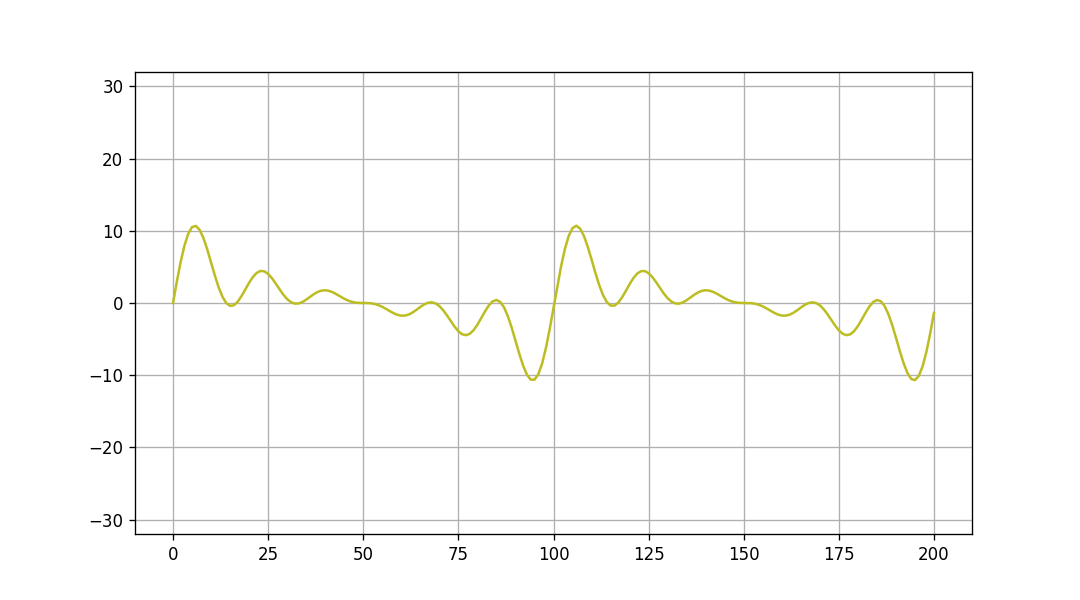

interactive(children=(IntSlider(value=0, description='value', layout=Layout(width='100%'), max=32767), Output(…

In [14]:
fig, ax = plt.subplots(figsize=(9, 5))
ax.set_ylim([-32, 32])
ax.grid(True)

out = np.zeros(CHUNK)

def graph_ifft(value):

    harms = 6 #number of harmonics
    amps = 2 #granularity of amplitude control 

    xs = np.arange(CHUNK)
    mult = 2 * np.pi * 440 / 44100

    t = decode(value, harms, amps)

    out = np.zeros(len(xs))    
    
    for i in range(harms):
        out += t[i] * np.sin(xs * mult * (i + 1))
    print("value: ", t)
    
    ax.lines=[]
    ax.plot(out)
    fig.show()
    
    for i in range(220):
        stream.write(out)
    
interact(graph_ifft, value=IntSlider(0, 0, (1<<15) - 1, 1, layout=Layout(width='100%')))

pass

In [ ]:
# set up plot
fig, ax = plt.subplots(figsize=(6, 4))
ax.set_ylim([-4, 4])
ax.grid(True)
 
# generate x values
x = np.linspace(0, 2 * np.pi, 100)

def my_sine(x, w, amp, phi):
    """
    Return a sine for x with angular frequeny w and amplitude amp.
    """
    return amp*np.sin(w * (x-phi))

@interact(w=(0, 10, 1), amp=(0, 4, .1), phi=(0, 2*np.pi+0.01, 0.01))
def update(w = 1.0, amp=1, phi=0):
    """Remove old lines from plot and plot new one"""
    [l.remove() for l in ax.lines]
    ax.plot(x, my_sine(x, w, amp, phi), color='C0')